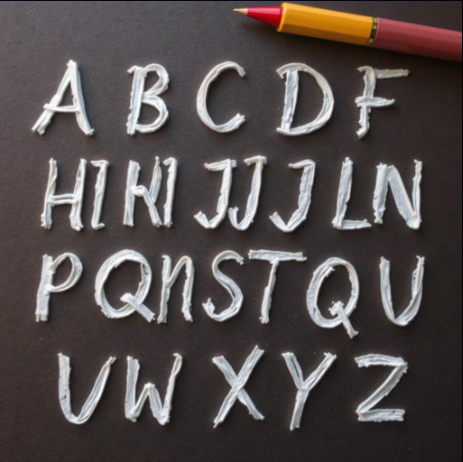

In [113]:
from IPython.display import Image, display

display(Image(filename="/kaggle/input/hobahoba/bsdbbasdjbasdb.PNG", width=400))

## Import All Required Libraries

In [80]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support, roc_auc_score
from IPython.display import Image

## Basic Residual Block for Convolutional Networks

In [3]:
def basic_block(x, filters, stride=1, downsample=False):
    identity = x
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    if downsample:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride)(identity)
        identity = layers.BatchNormalization()(identity)
    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

## Bottleneck Residual Block for Convolutional Networks

In [4]:
def bottleneck_block(x, filters, stride=1, downsample=False):
    identity = x
    x = layers.Conv2D(filters, kernel_size=1, strides=1, padding="valid")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters * 4, kernel_size=1, strides=1, padding="valid")(x)
    x = layers.BatchNormalization()(x)
    if downsample:
        identity = layers.Conv2D(filters * 4, kernel_size=1, strides=stride)(identity)
        identity = layers.BatchNormalization()(identity)
    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

## ResNet Layer with Configurable Blocks

In [5]:
def resnet_layer(x, block, filters, blocks, stride=1):
    x = block(x, filters, stride=stride, downsample=(stride != 1))
    for _ in range(1, blocks):
        x = block(x, filters)
    return x

## ResNet Model Builder with Configurable Layers and Blocks

In [6]:
def build_resnet(input_shape, num_classes, block_type, layer_counts):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)
    block = basic_block if block_type == "basic" else bottleneck_block
    x = resnet_layer(x, block, 64, layer_counts[0], stride=1)
    x = resnet_layer(x, block, 128, layer_counts[1], stride=2)
    x = resnet_layer(x, block, 256, layer_counts[2], stride=2)
    x = resnet_layer(x, block, 512, layer_counts[3], stride=2)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

## Configuration: Image Dimensions, Classes, Batch Size, and Epochs

In [7]:
img_width, img_height = 28, 28
num_classes = 26
batch_size = 40
epochs = 15

## Mount Drive and Define EMNIST Dataset Paths

In [8]:
train_path = "/kaggle/input/emnist/emnist-letters-train.csv"
test_path = "/kaggle/input/emnist/emnist-letters-test.csv"

## Load and Preprocess EMNIST Dataset from CSV File

In [68]:
def load_emnist_data(csv_file):
    data = pd.read_csv(csv_file, header=None)
    labels = data.iloc[:, 0].values
    labels = labels - 1
    images = data.iloc[:, 1:].values / 255.0
    images = images.reshape(-1, img_height, img_width, 1)
    return images, labels

## Load Training and Testing Data for EMNIST Dataset

In [69]:
X_train, y_train = load_emnist_data(train_path)
X_test, y_test = load_emnist_data(test_path)

train_classes = np.unique(y_train)
test_classes = np.unique(y_test)
missing_classes = np.setdiff1d(train_classes, test_classes)
print(f"Classes in training set but missing in test set: {missing_classes}")

if len(missing_classes) > 0:
    additional_test_images = []
    additional_test_labels = []

    for cls in missing_classes:
        cls_indices = np.where(y_train == cls)[0]
        cls_train_indices, cls_test_indices = train_test_split(cls_indices, test_size=0.2, random_state=42)

        additional_test_images.append(X_train[cls_test_indices])
        additional_test_labels.append(y_train[cls_test_indices])

        X_train = np.delete(X_train, cls_test_indices, axis=0)
        y_train = np.delete(y_train, cls_test_indices, axis=0)

    additional_test_images = np.concatenate(additional_test_images, axis=0)
    additional_test_labels = np.concatenate(additional_test_labels, axis=0)

    X_test = np.concatenate((X_test, additional_test_images), axis=0)
    y_test = np.concatenate((y_test, additional_test_labels), axis=0)

print(f"Updated test dataset now includes all classes.")
print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

Classes in training set but missing in test set: [19 20 21 22 23 24 25]
Updated test dataset now includes all classes.
Training set size: 83993
Test set size: 19607


## Split EMNIST Training Data into Training and Validation Sets

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Visualize First 10 Images from EMNIST Training Set

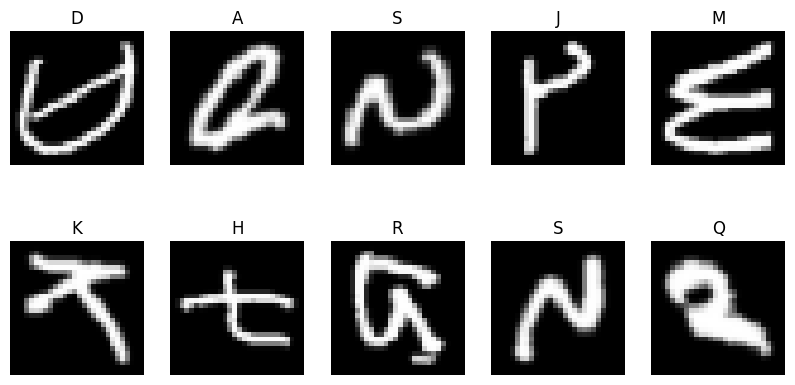

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray')
    plt.title(chr(y_train[i] + ord('A')))
    plt.axis('off')
plt.show()

## One-Hot Encode EMNIST Labels for Training, Validation, and Testing

In [13]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

## Build ResNet Model with Basic Blocks for EMNIST Dataset

In [14]:
model = build_resnet(input_shape=(img_height, img_width, 1), num_classes=num_classes, block_type="basic", layer_counts=[2, 2, 2, 2])

## Compile ResNet Model with Adam Optimizer and Categorical Crossentropy Loss

In [15]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

## Train ResNet Model on EMNIST Dataset with Validation

In [16]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/15


I0000 00:00:1734539074.214438      90 service.cc:145] XLA service 0x7bf120007150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734539074.214532      90 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734539074.214539      90 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   7/1680 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - accuracy: 0.1652 - loss: 3.9831 

I0000 00:00:1734539083.528544      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1680/1680 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.7723 - loss: 0.8055 - val_accuracy: 0.8032 - val_loss: 0.6941
Epoch 2/15
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9029 - loss: 0.2862 - val_accuracy: 0.8861 - val_loss: 0.3746
Epoch 3/15
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9194 - loss: 0.2347 - val_accuracy: 0.9137 - val_loss: 0.2621
Epoch 4/15
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9283 - loss: 0.2057 - val_accuracy: 0.9301 - val_loss: 0.2186
Epoch 5/15
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9328 - loss: 0.1887 - val_accuracy: 0.9260 - val_loss: 0.2418
Epoch 6/15
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9395 - loss: 0.1687 - val_accuracy: 0.9305 - val_loss: 0.2235
Epoch 7/15
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9443 - loss: 0.1539 - val_accuracy: 0.9383 - val_loss: 0.1987
Epoch 8/15
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9458 - loss: 0.14

In [17]:
model.save('/content/drive/MyDrive/ResNetModel.h5')

## Evaluate ResNet Model on Training and Test Sets

In [18]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Training accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

2100/2100 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9657 - loss: 0.0807
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9444 - loss: 0.2052
Training accuracy: 0.97
Test accuracy: 0.94


## Make Predictions on First 10 Samples of Training and Test Sets

In [19]:
train_predictions = model.predict(X_train[:10])
test_predictions = model.predict(X_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


## Extract Predicted and True Labels for First 10 Samples in Training and Test Sets

In [20]:
train_predicted_labels = np.argmax(train_predictions, axis=1)
test_predicted_labels = np.argmax(test_predictions, axis=1)
train_true_labels = np.argmax(y_train[:10], axis=1)
test_true_labels = np.argmax(y_test[:10], axis=1)

## Visualize Predictions vs True Labels for First 10 Training and Test Samples

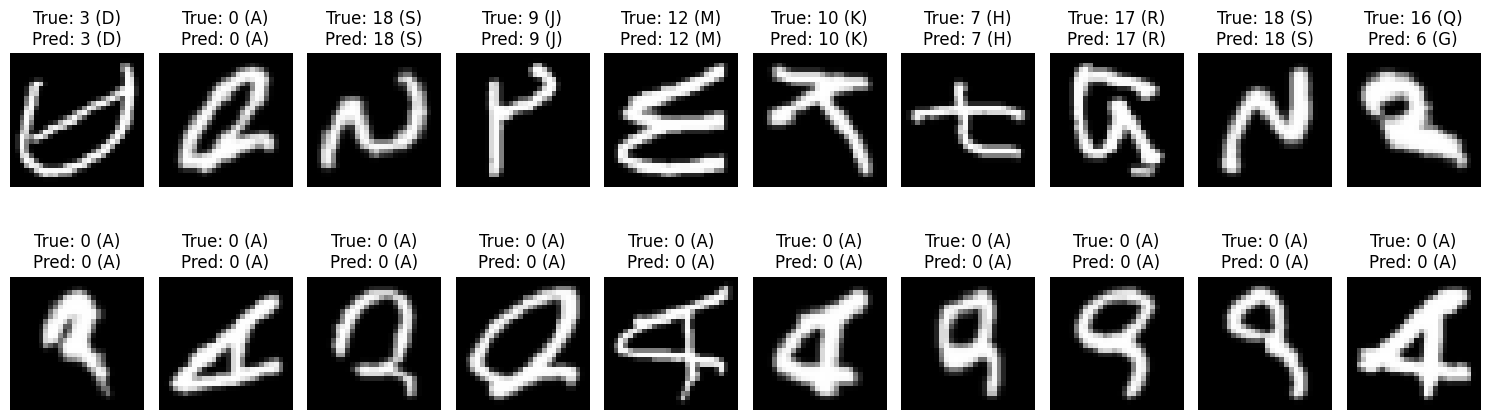

In [21]:
label_to_letter = {i: chr(65 + i) for i in range(26)}

plt.figure(figsize=(15, 5))
for i in range(10):
    true_label = train_true_labels[i]
    pred_label = train_predicted_labels[i]
    true_letter = label_to_letter[true_label]
    pred_letter = label_to_letter[pred_label]

    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray')
    plt.title(f"True: {true_label} ({true_letter})\nPred: {pred_label} ({pred_letter})")
    plt.axis('off')

for i in range(10):
    true_label = test_true_labels[i]
    pred_label = test_predicted_labels[i]
    true_letter = label_to_letter[true_label]
    pred_letter = label_to_letter[pred_label]

    plt.subplot(2, 10, i+11)
    plt.imshow(X_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f"True: {true_label} ({true_letter})\nPred: {pred_label} ({pred_letter})")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Visualize Training and Validation Accuracy and Loss Across Epochs

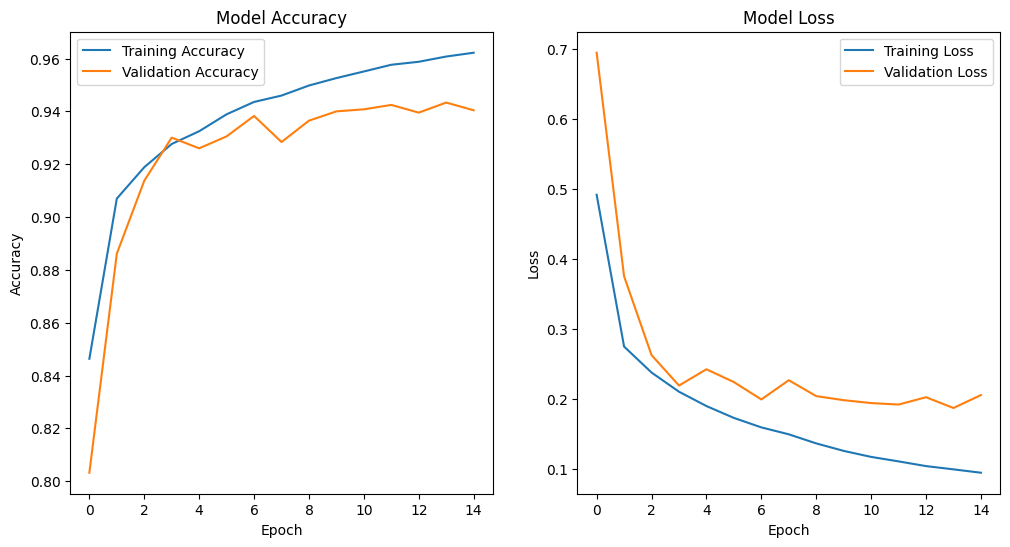

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Confusion Matrix for EMNIST Validation Set Predictions

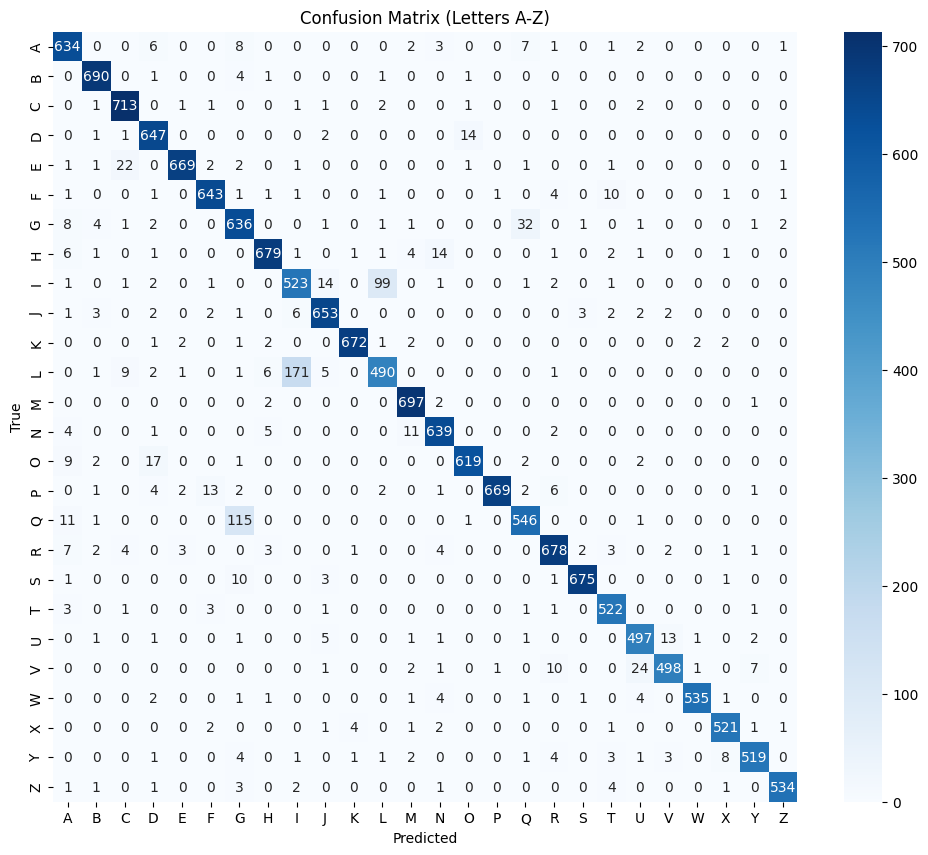

In [49]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

class_names = [chr(i + ord('A')) for i in range(26)]

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Letters A-Z)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Precision, Recall, F1-Score, and Classification Report

In [50]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {fscore:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

Precision: 0.9415
Recall: 0.9404
F1-Score: 0.9403

Classification Report:
              precision    recall  f1-score   support

           A       0.92      0.95      0.94       665
           B       0.97      0.99      0.98       698
           C       0.95      0.98      0.97       724
           D       0.93      0.97      0.95       665
           E       0.99      0.95      0.97       702
           F       0.96      0.97      0.96       666
           G       0.80      0.92      0.86       691
           H       0.97      0.95      0.96       713
           I       0.74      0.81      0.77       646
           J       0.95      0.96      0.96       677
           K       0.99      0.98      0.99       685
           L       0.82      0.71      0.76       687
           M       0.96      0.99      0.98       702
           N       0.95      0.97      0.96       662
           O       0.97      0.95      0.96       652
           P       1.00      0.95      0.97       703
       

### ROC Curves and Compute AUC for Multi-Class Classification

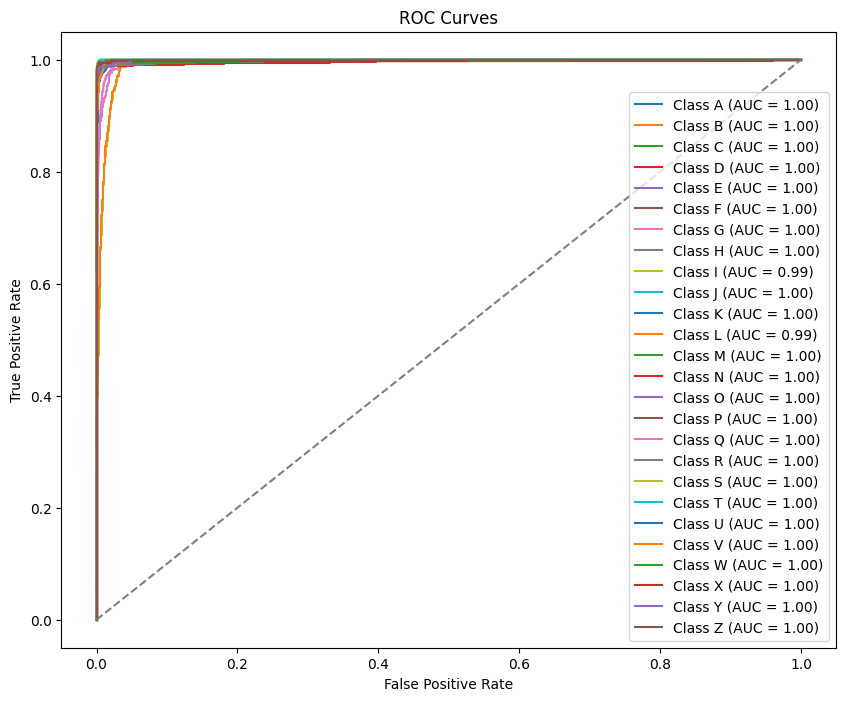

Overall Weighted AUC: 0.9983


In [51]:
y_val_bin = label_binarize(y_true_classes, classes=list(range(num_classes)))
y_pred_bin = y_pred

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

overall_auc = roc_auc_score(y_val_bin, y_pred_bin, average='weighted', multi_class='ovr')
print(f"Overall Weighted AUC: {overall_auc:.4f}")

In [78]:
y_train.shape

(67194,)